<a href="https://colab.research.google.com/github/samuelpndx/time-series-sunspot/blob/main/time_series_sunspot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

# Utils

In [ ]:
def plot_series(x, y, format='-', start=0, end=None,
                title=None, xlabel=None, ylabel=None,
                legend=None):
  plt.figure(figsize=(10,6))

  if type(y) is tuple:
    for y_curr in y:
      plt.plot(x[start:end], y_curr[start:end], format)

  else:
    plt.plot(x[start:end], y[start:end], format)

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if legend:
    plt.legend(legend)
  plt.title(title)
  plt.grid(True)
  plt.show()

In [ ]:
def model_forecast(model, serie, window_size, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(batch_size).prefetch(1)
  forecast = model.predict(dataset, verbose=0)
  return forecast

# Load the data

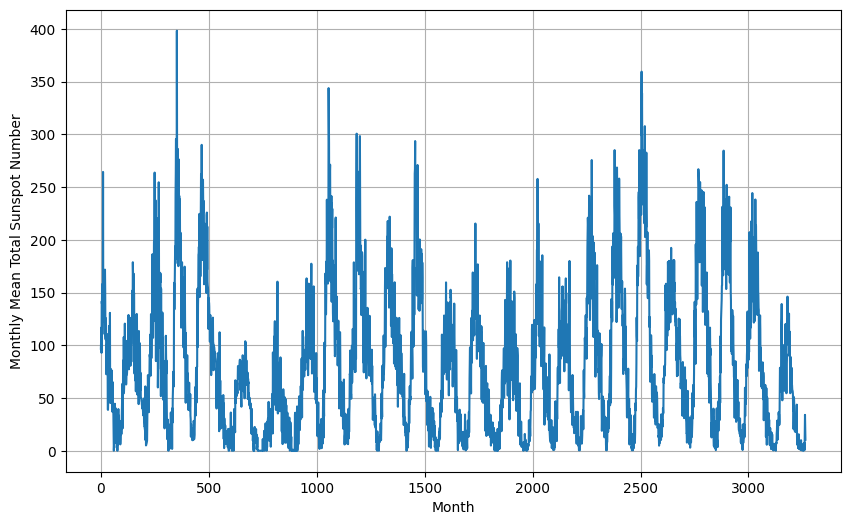

In [ ]:
time_steps = []
sunspots = []

with open('/content/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    time_steps.append(int(row[0]))
    sunspots.append(float(row[2]))
time = np.array(time_steps)
series = np.array(sunspots)

plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

# Split the Dataset

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# Prepare features and labels

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size)
  dataset = dataset.cache().prefetch(1)

  return dataset

# DNN - window_size = 20

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

loss = 'mse'
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(train_set, epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4418.0391
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 878.1942
Epoch 3/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 502.4266

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 664.7640
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 632.2382
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 617.4666
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 605.4021
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 596.1805
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 588.7349
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 582.4846
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 577.0181
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 572.1234
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 567.7997
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 563.9644
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 560.4241
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 557.3427
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 554.5117
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

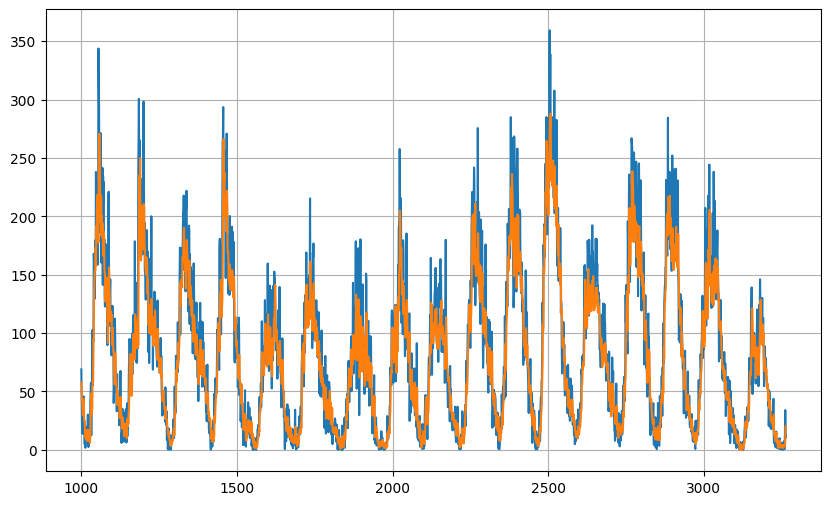

In [ ]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [ ]:
print(tf.keras.metrics.mae(x_valid, results).numpy())

18.60575


# DNN - window size = 132

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 132
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

loss = 'mse'
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(train_set, epochs=100)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3246.7754
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1012.1403
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 832.8360
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 797.2446 
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 770.2073
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 726.8310
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 710.5780
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 687.7496
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 666.8510
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 654.7100
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 640.2419
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 635.2659
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 614.5753
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 602.5547
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━

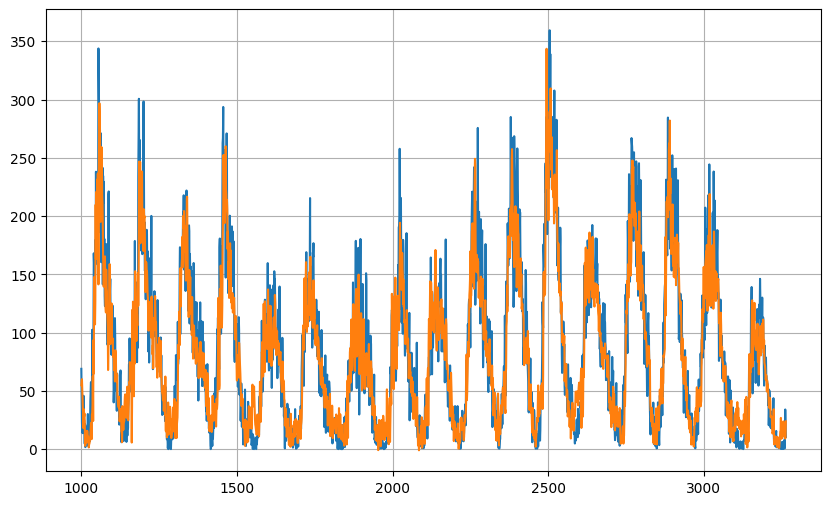

In [ ]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [ ]:
print(tf.keras.metrics.mae(x_valid, results).numpy())

21.756397


# DNN window size=30 and split time = 3000

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

loss = 'mse'
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1989.8114
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 756.4648
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 697.8113
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 667.3259
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 650.0209
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 638.0298
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 629.4990
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 622.3491
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 618.6334
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 614.0856
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 610.3137
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 608.0165
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 605.7884
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 603.9966
Epoch 15/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s

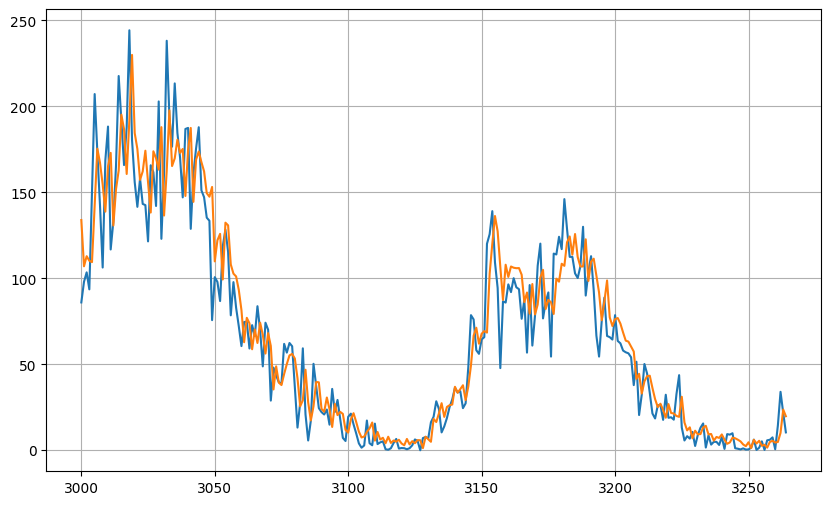

In [ ]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [ ]:
print(tf.keras.metrics.mae(x_valid, results).numpy())

13.846646


# DNN with new neurons number

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(1)
])

loss = 'mse'
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6799.8071
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 844.7058
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 792.3088
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 750.2625
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 718.7625
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 697.9200
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 681.6644
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 669.7722
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 662.1396
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 654.3208
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 648.9301
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 644.6502
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 640.0708
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 637.1896
Epoch 15/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0

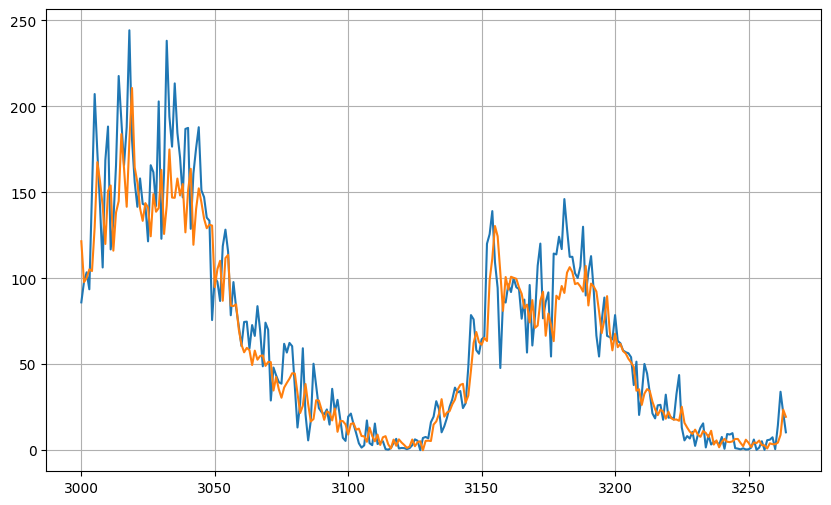

In [ ]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [ ]:
print(tf.keras.metrics.mae(x_valid, results).numpy())

14.097403


# DNN new learning rate

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 32
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

loss = 'mse'
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2287.3315
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1172.2344
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1032.7241
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 952.9620
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 901.4711
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 861.8169
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 834.4119
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 813.4065
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 796.2943
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 781.6887
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 769.7755
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 759.6916
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 750.9590
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 742.9450
Epoch 15/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 

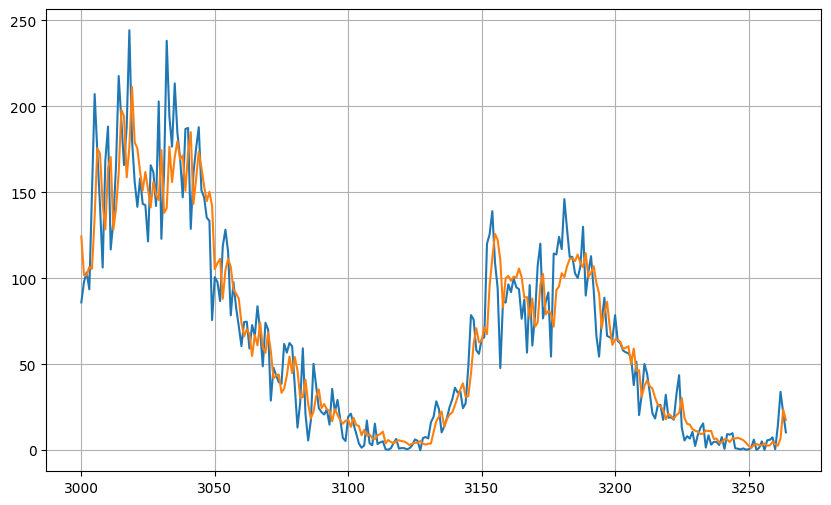

In [ ]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [ ]:
print(tf.keras.metrics.mae(x_valid, results).numpy())

13.572906


# DNN tunning learning rate

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,251 (4.89 KB)

 Trainable params: 1,251 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch /20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 89.1418 - learning_rate: 1.0000e-08
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88.7646 - learning_rate: 1.1220e-08
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88.3360 - learning_rate: 1.2589e-08
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87.8620 - learning_rate: 1.4125e-08
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87.3373 - learning_rate: 1.5849e-08
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.7580 - learning_rate: 1.7783e-08
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.1160 - learning_rate: 1.9953e-08
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85.4061 - learning_rate: 2.2387e-08
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84.6223 - learning_rate: 2.5119e-08
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83.7561 - learning_rate: 2.8184e-08
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

(np.float64(1e-08), np.float64(0.001), np.float64(0.0), np.float64(100.0))

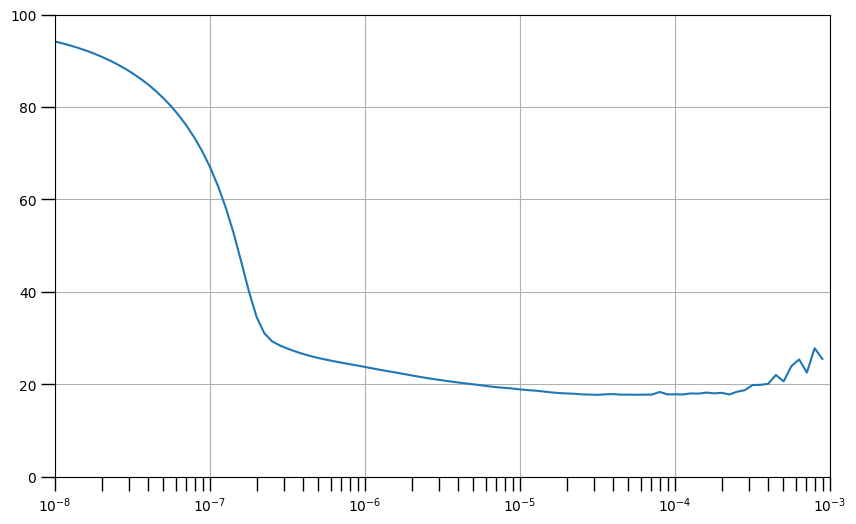

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-8, 1e-3, 0, 100])

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
learning_rate = 1e-5
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
loss = tf.keras.losses.Huber()
metrics = ['mae']
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 37.7101 - mae: 38.2045
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.4603 - mae: 21.9532
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.2745 - mae: 20.7671
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.6091 - mae: 20.1017
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.2330 - mae: 19.7256
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.9294 - mae: 19.4210
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.6799 - mae: 19.1721
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.5206 - mae: 19.0133
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.4084 - mae: 18.9009
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.2661 - mae: 18.7607
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.1812 - mae: 18.6737
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.0688 - mae: 18.5622
Epoch 13/100


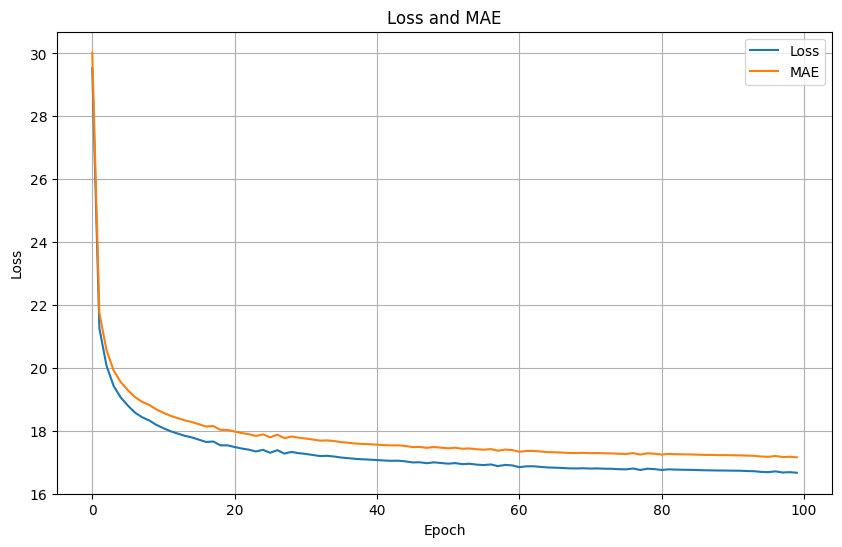

In [ ]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["mae"])
plt.title("Loss and MAE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Loss", "MAE"])
plt.show()

In [ ]:
def model_forecast(model, serie, window_size, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(batch_size).prefetch(1)
  forecast = model.predict(dataset, verbose=0)
  return forecast

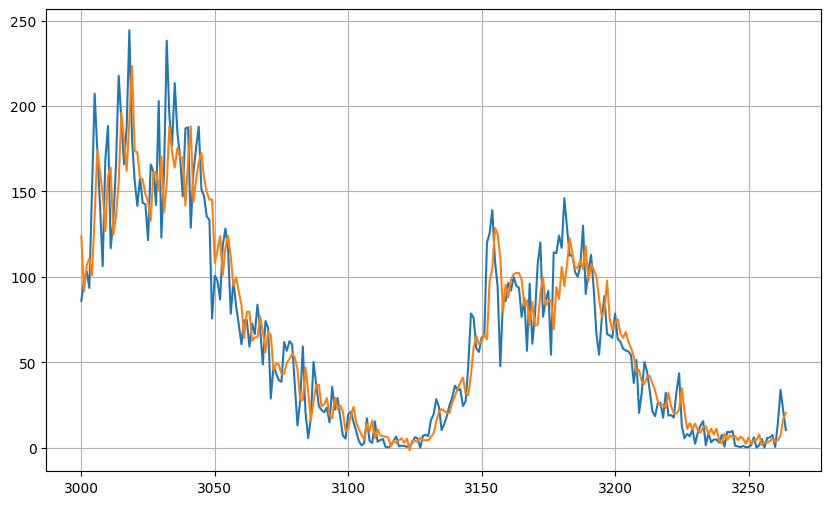

In [ ]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [ ]:
print(tf.keras.metrics.mae(x_valid, results).numpy())

14.047279


# Conv and LSTM

In [ ]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=3,
                           strides=1,
                           activation='relu',
                           padding='causal'),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 30, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           1,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,255 (235.37 KB)

 Trainable params: 60,255 (235.37 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
init_weights = model.get_weights()

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch /20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 88.1225 - learning_rate: 1.0000e-08
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 67.5518 - learning_rate: 1.1220e-08
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 62.9964 - learning_rate: 1.2589e-08
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 59.7332 - learning_rate: 1.4125e-08
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 56.6955 - learning_rate: 1.5849e-08
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 53.7363 - learning_rate: 1.7783e-08
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 50.9780 - learning_rate: 1.9953e-08
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 48.4949 - learning_rate: 2.2387e-08
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 46.2081 - learning_rate: 2.5119e-08
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 44.0776 - learning_rate: 2.8184e-08
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/st

(np.float64(1e-08), np.float64(0.001), np.float64(0.0), np.float64(100.0))

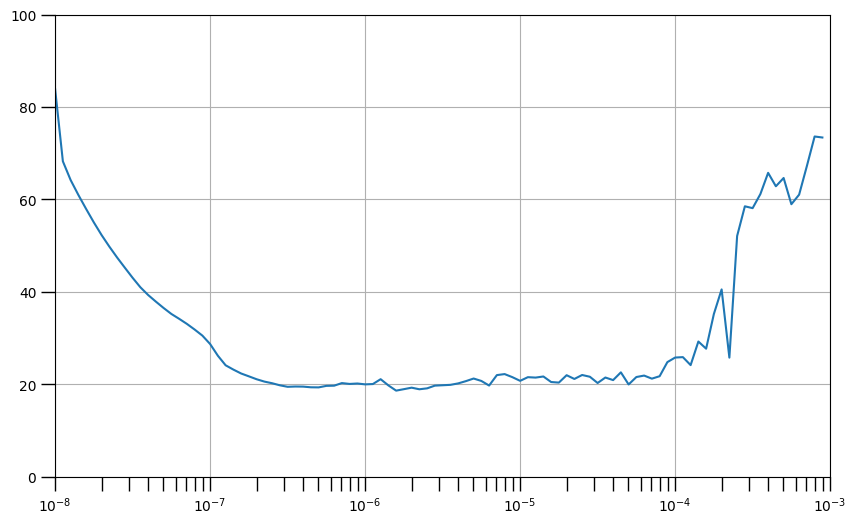

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [ ]:
tf.keras.backend.clear_session()
model.set_weights(init_weights)

In [ ]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 57.7129 - mae: 58.2097
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 28.3662 - mae: 28.8606
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 22.3399 - mae: 22.8337
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.1037 - mae: 21.5981
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 20.8016 - mae: 21.2947
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 20.0933 - mae: 20.5874
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 20.0570 - mae: 20.5500
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 19.4807 - mae: 19.9736
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 19.3067 - mae: 19.7993
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.8016 - mae: 19.2934
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.7236 - mae: 19.2165
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.6446 - mae: 19.1374
Epoch 13/100


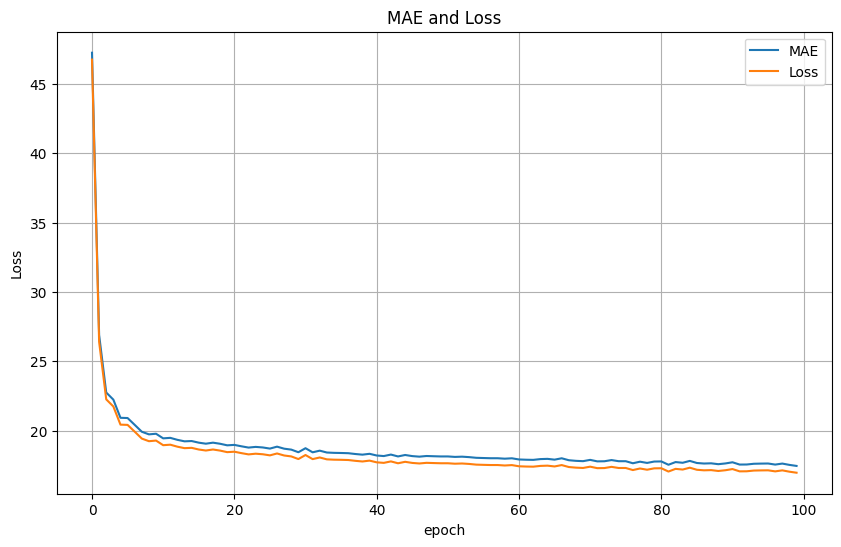

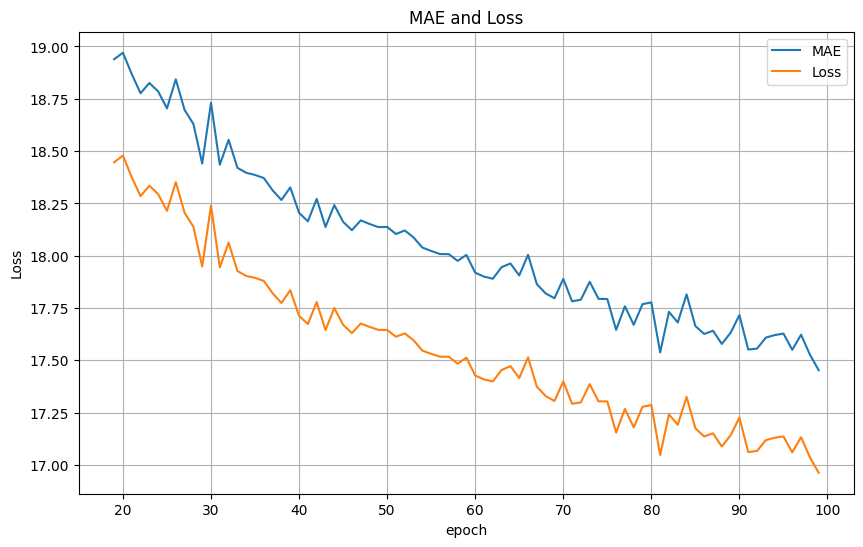

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

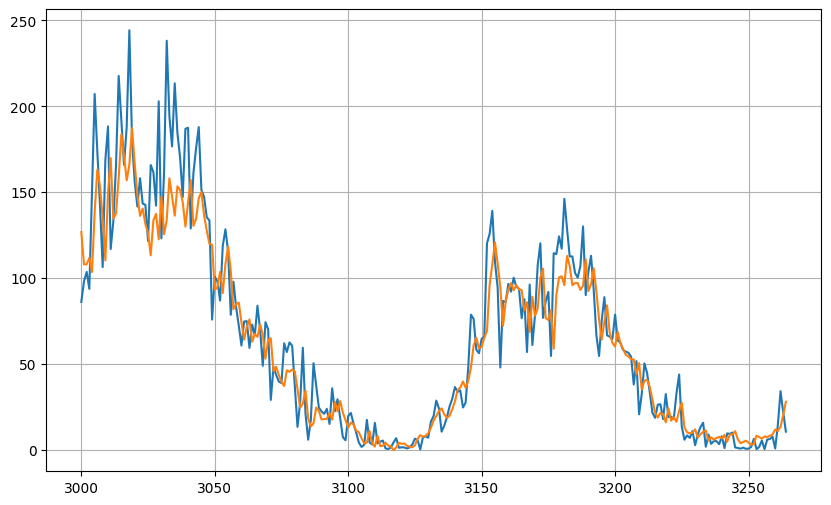

In [ ]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [ ]:
print(tf.keras.metrics.mae(x_valid, results).numpy())

13.752517


# All together

In [ ]:
tf.keras.backend.clear_session()

window_size = 60
batch_size = 250
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Conv1D(filters=60,
                           kernel_size=5,
                           strides=1,
                           padding='causal',
                           activation='relu'),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
loss = tf.keras.losses.Huber()
metrics = ['mae']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
history = model.fit(train_set, epochs=500)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 50.0887 - mae: 50.5870
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 30.1181 - mae: 30.6126
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 27.4248 - mae: 27.9195
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 23.5893 - mae: 24.0836
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 20.7879 - mae: 21.2826
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 20.7999 - mae: 21.2937
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.2705 - mae: 19.7646
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.7960 - mae: 19.2892
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.1876 - mae: 19.6790
Epoch 10/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.2754 - mae: 18.7696
Epoch 11/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.4187 - mae: 18.9123
Epoch 12/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.7415 - mae: 20.2336
Epoc

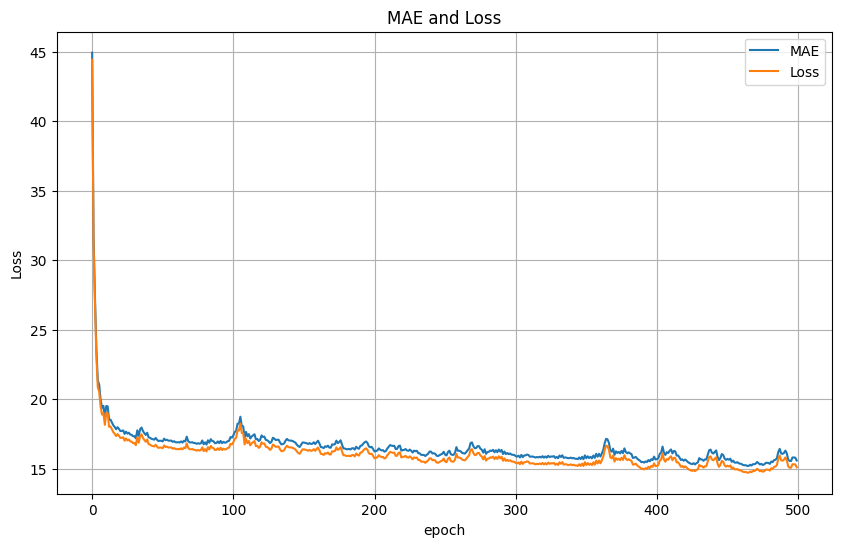

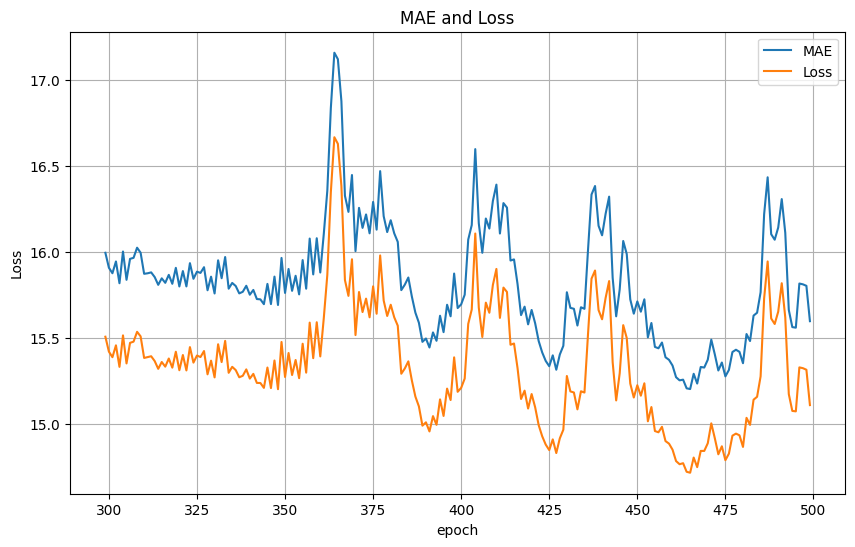

In [56]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.6)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [57]:
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [60]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, series[split_time-window_size:-1], window_size).squeeze()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


<Figure size 1000x600 with 0 Axes>

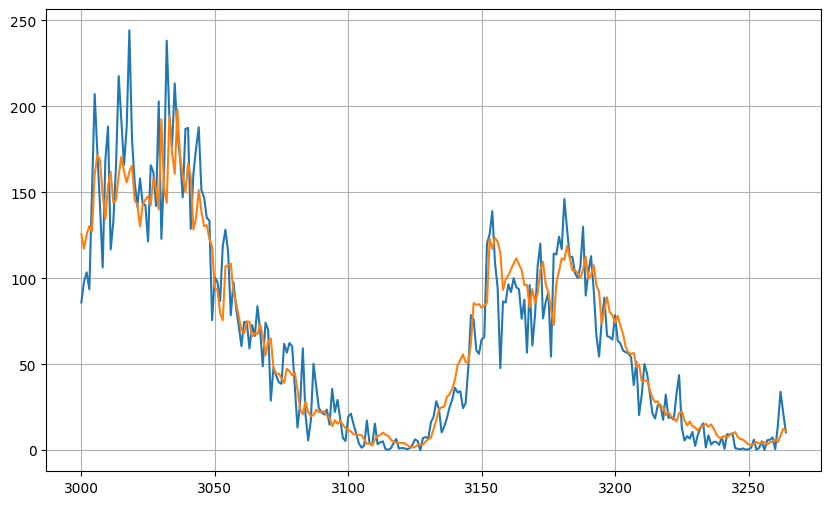

In [65]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, (x_valid, rnn_forecast))
